In [10]:
# Install all dependencies
!pip install pandas matplotlib nltk transformers --quiet


In [11]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("vader_lexicon")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91902\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91902\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91902\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91902\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline


In [13]:
# Sample embedded dataset (small for demo)
sample_data = {
    "review": [
        "I loved this movie, it was fantastic and thrilling!",
        "Terrible movie. Waste of time.",
        "The plot was okay but the acting was superb.",
        "Not my cup of tea. Boring and slow.",
        "Absolutely amazing performance by the cast!"
    ]
}
df = pd.DataFrame(sample_data)

# If you have the full IMDB Dataset.csv file in the same folder, uncomment below:
# df = pd.read_csv("IMDB Dataset.csv")

df.head()


,review
0,"I loved this movie, it was fantastic and thril..."
1,Terrible movie. Waste of time.
2,The plot was okay but the acting was superb.
3,Not my cup of tea. Boring and slow.
4,Absolutely amazing performance by the cast!


In [14]:
def clean_text(text: str) -> str:
    text = str(text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower().strip()
    tokens = nltk.word_tokenize(text)
    sw = set(stopwords.words("english"))
    tokens = [t for t in tokens if t not in sw and len(t) > 1]
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(t) for t in tokens]
    return " ".join(tokens)

TEXT_COL = "review"
df["clean_text"] = df[TEXT_COL].astype(str).apply(clean_text)
df.head()


,review,clean_text
0,"I loved this movie, it was fantastic and thril...",loved movie fantastic thrilling
1,Terrible movie. Waste of time.,terrible movie waste time
2,The plot was okay but the acting was superb.,plot okay acting superb
3,Not my cup of tea. Boring and slow.,cup tea boring slow
4,Absolutely amazing performance by the cast!,absolutely amazing performance cast


In [15]:
vader = SentimentIntensityAnalyzer()
df["vader_score"] = df["clean_text"].apply(lambda x: vader.polarity_scores(x)["compound"])
df["vader_label"] = df["vader_score"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))
df[["review", "vader_score", "vader_label"]]


,review,vader_score,vader_label
0,"I loved this movie, it was fantastic and thril...",0.8910,Positive
1,Terrible movie. Waste of time.,-0.7096,Negative
2,The plot was okay but the acting was superb.,0.7184,Positive
3,Not my cup of tea. Boring and slow.,-0.3182,Negative
4,Absolutely amazing performance by the cast!,0.6240,Positive


In [16]:
hf_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
hf_results = hf_classifier(df["review"].astype(str).tolist(), truncation=True)

df["hf_label"] = [res["label"] for res in hf_results]
df["hf_confidence"] = [res["score"] for res in hf_results]
df[["review", "hf_label", "hf_confidence"]]


Device set to use cpu


,review,hf_label,hf_confidence
0,"I loved this movie, it was fantastic and thril...",POSITIVE,0.999888
1,Terrible movie. Waste of time.,NEGATIVE,0.999812
2,The plot was okay but the acting was superb.,POSITIVE,0.999813
3,Not my cup of tea. Boring and slow.,NEGATIVE,0.999693
4,Absolutely amazing performance by the cast!,POSITIVE,0.999880


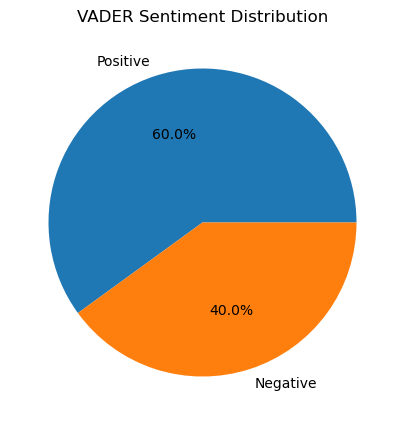

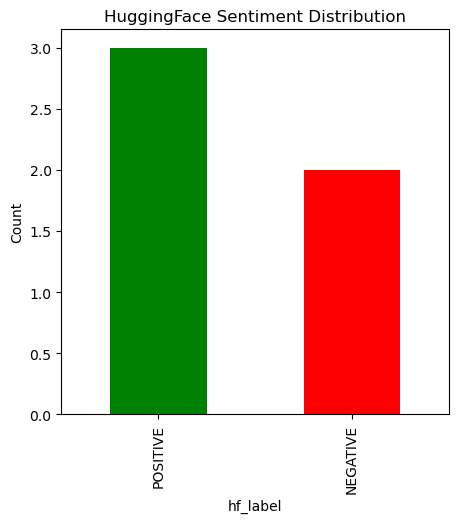

In [17]:
# Pie chart for VADER
vader_counts = df["vader_label"].value_counts()
plt.figure(figsize=(5,5))
plt.pie(vader_counts, labels=vader_counts.index, autopct="%1.1f%%")
plt.title("VADER Sentiment Distribution")
plt.savefig("vader_pie_chart.png")
plt.show()

# Bar chart for HuggingFace
hf_counts = df["hf_label"].value_counts()
plt.figure(figsize=(5,5))
hf_counts.plot(kind="bar", color=["green", "red"])
plt.title("HuggingFace Sentiment Distribution")
plt.ylabel("Count")
plt.savefig("hf_bar_chart.png")
plt.show()


In [18]:
df.to_csv("sentiment_analysis_results.csv", index=False)
print("Results saved to sentiment_analysis_results.csv")


Results saved to sentiment_analysis_results.csv


In [20]:
# =====================================
# STEP 11: Optional UI with Streamlit
# =====================================
import streamlit as st
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

# Load VADER
vader = SentimentIntensityAnalyzer()

# Load HuggingFace sentiment pipeline
hf_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

st.title("🎬 Movie Review Sentiment Analysis")
st.write("Paste a review below to see sentiment analysis from both VADER and HuggingFace Transformer.")

# Input text
user_review = st.text_area("Enter your movie review here:")

if st.button("Analyze Sentiment"):
    if user_review.strip() != "":
        # VADER Analysis
        vader_scores = vader.polarity_scores(user_review)
        if vader_scores['compound'] >= 0.05:
            vader_sentiment = "Positive"
        elif vader_scores['compound'] <= -0.05:
            vader_sentiment = "Negative"
        else:
            vader_sentiment = "Neutral"
        
        # HuggingFace Analysis
        hf_result = hf_pipeline(user_review)[0]
        hf_sentiment = hf_result['label']
        hf_score = hf_result['score']

        # Display results
        st.subheader("📊 VADER Sentiment")
        st.write(f"Sentiment: **{vader_sentiment}**")
        st.json(vader_scores)

        st.subheader("🤖 HuggingFace Transformer Sentiment")
        st.write(f"Sentiment: **{hf_sentiment}** (Confidence: {hf_score:.2f})")

    else:
        st.warning("Please enter a review before analyzing.")


Device set to use cpu
2025-08-14 21:46:54.051 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:46:54.056 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:46:54.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:46:54.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:46:54.064 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:46:54.066 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:46:54.068 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 21:46:54.070 Thread 'MainThread': missing ScriptRunContext! This warning can be ignor